<h2>Loading and preprocessing the data

In [1]:
from moabb.datasets import BNCI2014_001
from moabb.paradigms import MotorImagery

import matplotlib.pyplot as plt
import numpy as np

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline

from mne import Epochs, pick_types
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.io import concatenate_raws, read_raw_edf

'''
2 sessions, 
    - 6 runs in each session, 
    - 12*4(=48) trials in each run,
    - 288 trials in each session.
    - 25 channels - (first 22 are EEG, last 3 are EOG) - need to remove those
    - cue onset classes and event type values: in training data 1, 2, 3, 4 -> 769, 770, 771, 772
    - trials containing artifacts as scored by experts are marked as events
      with the type 1023
'''
dataset = BNCI2014_001()
#dataset.subject_list = dataset.subject_list[:3]
datasets = [dataset]
paradigm = MotorImagery()

subject_list = [1]
sessions = dataset.get_data(subject_list)

#returns mne epochs 
#not removed bads(might need to do that according to the paper), but removed eogs. Contains all the trials for subject 1
#epochs contains 576 trials, 288 trials for each of 2 sessions
epochs, labels, meta = paradigm.get_data( 
    dataset=dataset, subjects=subject_list, return_epochs=True
)

#Bandpass filter between to enhance mu and beta frequencies
epochs.filter(l_freq=7, h_freq=30)

'''
print(sessions[1]["0train"])
print("\n")
print(sessions[1]["1test"])
print("\n")
print(epochs.events)
print(epochs.event_id)
print(epochs.tmin, epochs.tmax)
'''



<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
c:\Users\Eier\miniconda3\envs\mne\Lib\site-packages\moabb\pipelines\__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(
Choosing from all possible events


To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
576 matching events found
No baseline correction applied
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff

c:\Users\Eier\miniconda3\envs\mne\Lib\site-packages\moabb\paradigms\base.py:354: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  X = mne.concatenate_epochs(X)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 3041 task

'\nprint(sessions[1]["0train"])\nprint("\n")\nprint(sessions[1]["1test"])\nprint("\n")\nprint(epochs.events)\nprint(epochs.event_id)\nprint(epochs.tmin, epochs.tmax)\n'

<h2>Classification with cps+lda

Computing rank from data with rank=None
    Using tolerance 3.2e-05 (2.2e-16 eps * 22 dim * 6.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.2e-05 (2.2e-16 eps * 22 dim * 6.6e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e-05 (2.2e-16 eps * 22 dim * 7.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e-05 (2.2e-16 eps * 22 dim * 7.1e+09  max singular value)


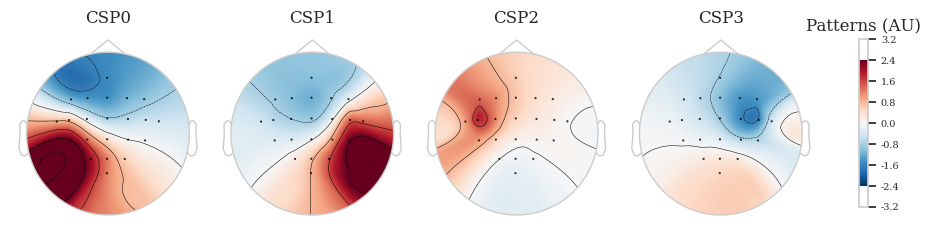

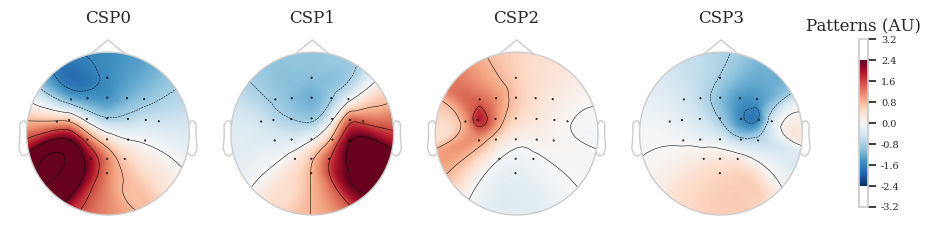

In [2]:
#Source: https://mne.tools/dev/auto_examples/decoding/decoding_csp_eeg.html 

#Asserting the epochs and labels (last row of the events matrix) to be used for the classification
epochs_train = epochs.copy()
labels = epochs.events[:, -1] - 4

#cross validation - (Might need to do cross session - session 1 as train, and session 2 as test. See dataset_structure.ipynb)
scores = []
epochs_data = epochs.get_data(copy=False)
epochs_data_train = epochs_train.get_data(copy=False)
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

#LDA and CSP pipeline
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
clf = Pipeline([("CSP", csp), ("LDA", lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

#Class balance between the 4 classes. 
class_balance = np.zeros(4)
for i in range(4):
    class_balance[i] = np.mean(labels == i)

class_balance = np.max(class_balance)
print("\n")
print("Scores:\n", scores)
print("\n")
print(f"Classification accuracy: {np.mean(scores)} / Chance level: {class_balance}")
print("\n")

csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)


<h2>Looking at performance over time

Computing rank from data with rank=None


    Using tolerance 3.2e-05 (2.2e-16 eps * 22 dim * 6.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.2e-05 (2.2e-16 eps * 22 dim * 6.6e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e-05 (2.2e-16 eps * 22 dim * 7.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e-05 (2.2e-16 eps * 22 dim * 7.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: ra

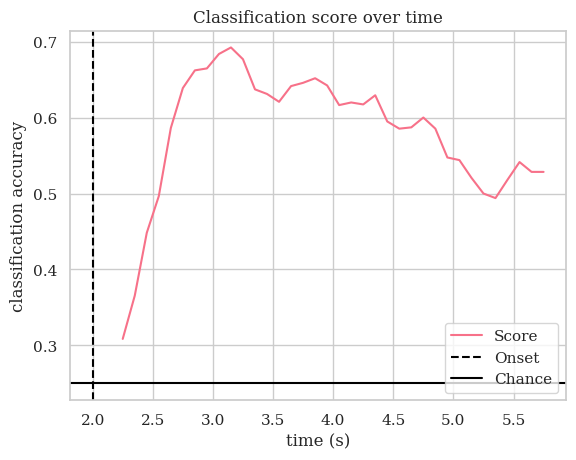

In [3]:
#Source: https://mne.tools/dev/auto_examples/decoding/decoding_csp_eeg.html

sfreq = 250 # Sampling frequency of 250 Hz as per the BCI competion dataset 2a

#Classify the signal using a sliding window

w_length = int(sfreq * 0.5)  #window length
w_step = int(sfreq * 0.1)  #window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step) #set of starting positions in the signal(Note! the signal is 2s to 4s)

scores_windows = []  

#Running classification across the signal
for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx] # get the current labels and data
    
    #Exatract spatial filters and transform the data as a whole
    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit the classifier on the training data
    lda.fit(X_train, y_train)

    # test the classifier on the windows. This is where we run over the signal
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)
    
# Plot the scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(2, linestyle="--", color="k", label="Onset")
plt.axhline(class_balance, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()